In [29]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split

!pip install -q git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm

In [30]:
path = '../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
fish_dirs = [dir for dir in os.listdir(path) if os.path.isdir(os.path.join(path, dir))]
fish_dirs

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

In [31]:
def load_image(path, output=False):
    img = cv2.imread(path)
    return np.array(img)

In [32]:
def load_mask(path, output=False):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return np.array(img).reshape(img.shape[0], img.shape[1], 1)

In [33]:
for dir in tqdm(fish_dirs):
    p = os.path.join(path, dir, dir)
    images = np.array([load_image(os.path.join(path, dir, dir, img)) for img in os.listdir(p)])
    masks = np.array([load_mask(os.path.join(path, dir, dir + " GT", img), output=True) for img in os.listdir(p)])

100%|██████████| 9/9 [01:53<00:00, 12.57s/it]


In [34]:
nr_tests = 300
images_train, images_test = images[:len(images)-nr_tests], images[len(images)-nr_tests:]
masks_train, masks_test = masks[:len(images)-nr_tests], masks[len(images)-nr_tests:]

dataset = {}
dataset['train'] = {'image':images_train, 'segmentation_mask':masks_train}
dataset['test'] = {'image':images_test, 'segmentation_mask':masks_test}

In [35]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.float32) / 255.0
    return input_image, input_mask

In [36]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [37]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [38]:
train_ds = tf.data.Dataset.from_tensor_slices(dataset['train'])
test_ds = tf.data.Dataset.from_tensor_slices(dataset['test'])

In [39]:
train = train_ds.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = test_ds.map(load_image_test)

In [40]:
TRAIN_LENGTH = len(train)
BATCH_SIZE = 64
BUFFER_SIZE = 300
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [41]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [42]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

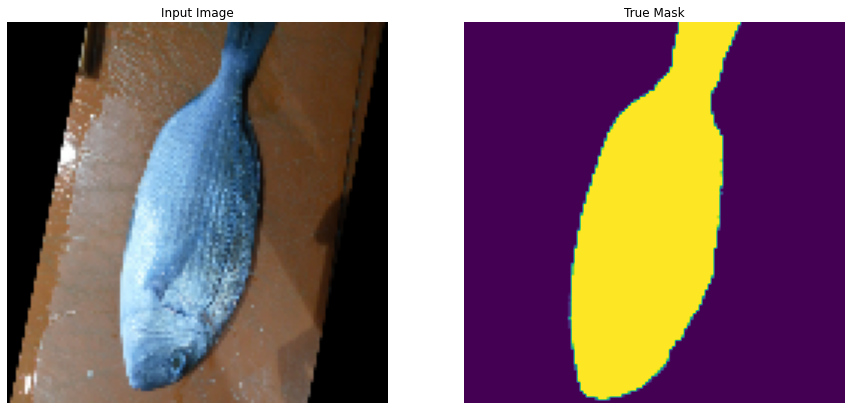

In [43]:
for image, mask in train.take(3):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [44]:
OUTPUT_CHANNELS = 3

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

In [45]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [46]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [47]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [48]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [49]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

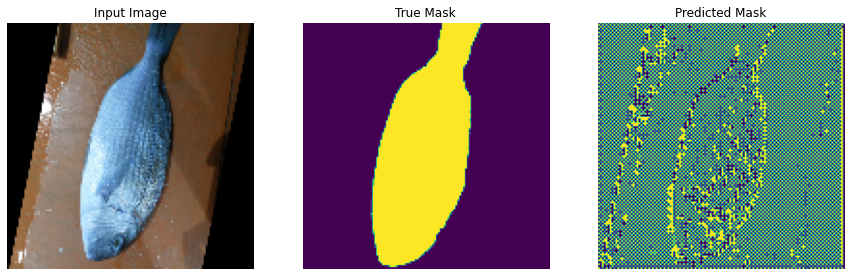

In [50]:
show_predictions(num=4)

In [51]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

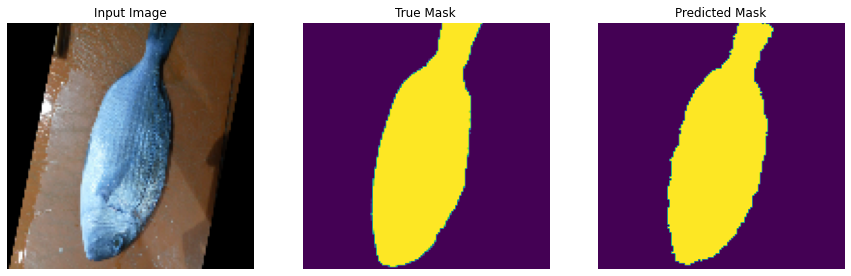


Sample Prediction after epoch 10



In [52]:
EPOCHS = 10
VALIDATION_STEPS = 10

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

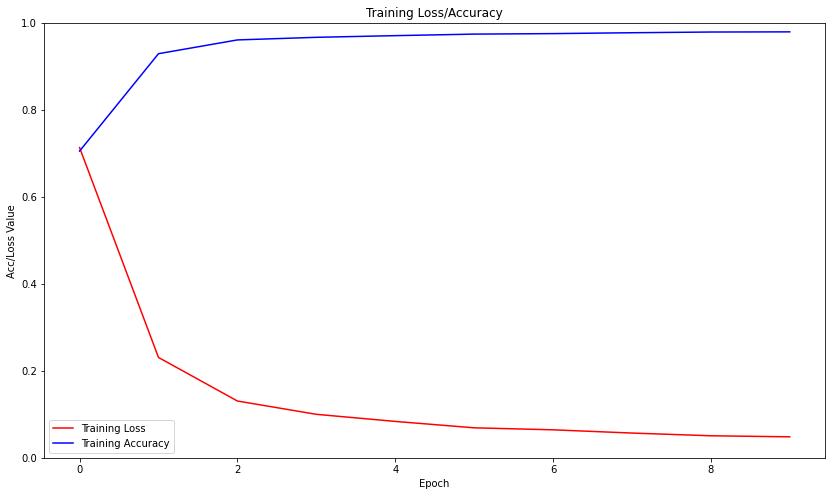

In [53]:
loss = model_history.history['loss']
acc = model_history.history['accuracy']

epochs = range(EPOCHS)

plt.figure(figsize=(14, 8))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.title('Training Loss/Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc/Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

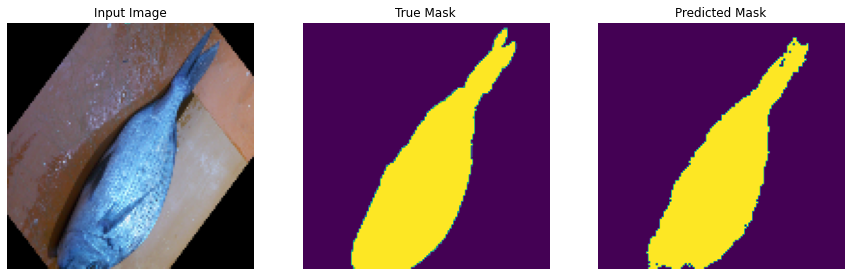

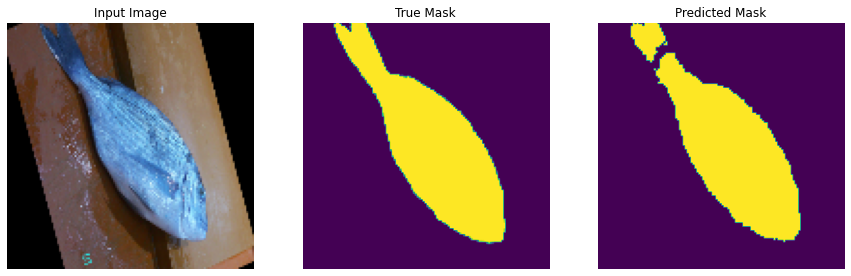

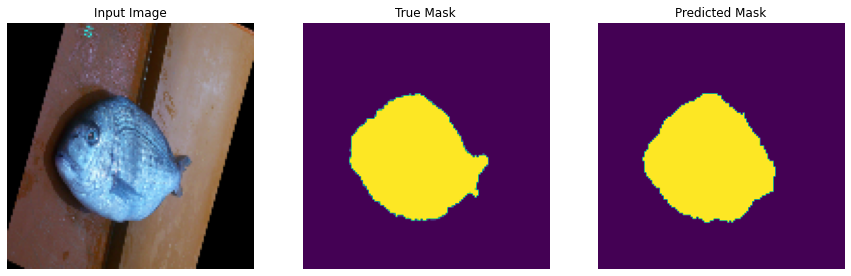

In [54]:
show_predictions(test_dataset, 3)